# Машинное обучение #

In [623]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import itertools
import warnings
warnings.filterwarnings("ignore")

## Этап 0 - загрузка датасета ##

In [583]:
df = pd.read_csv('dataset_after_EDA.csv', engine='python')
df = df.dropna() # в процессе выгрузки датасета после проведения EDA появились пропуски, попробуем найти неисправность
df.head()

,title,publishedAt,channelTitle,category,trending_date,tags,view_count,likes,comment_count,comments_disabled,ratings_disabled,description,country,subscriber_count,daytime,times_appeared
0,How the Warriors were in the Locker Room after...,2023-05-13 12:48:44,RDCworld1,Sports,2023-05-14,[none],1733159.0,132947.0,5374.0,False,False,Another installment to the Warriors Locker Roo...,United States,6320000.0,1.0,3.0
1,FlightReacts To #6 WARRIORS at #7 LAKERS | FUL...,2023-05-13 06:20:56,FlightReacts,Entertainment,2023-05-14,Reactions|Family|vlog|life|NBA|sports|Friends|...,668981.0,37032.0,3496.0,False,False,Thanks for Tuning In!! Lets Get 5 Million Toge...,United States,4830000.0,1.0,3.0
2,GUESS THE MOM! *Emotional Mother's Day Reveal*,2023-05-13 14:00:07,Jordan Matter,Entertainment,2023-05-14,jordan matter|salish matter|say say matter|bre...,4225973.0,87240.0,11058.0,False,False,Today we reveal my wife for the first time EVE...,United States,15900000.0,1.0,4.0
3,Why Lightbulbs Might Be The Best Invention Ever,2023-05-13 14:06:52,Veritasium,Education,2023-05-14,veritasium|science|physics,1008255.0,65421.0,2934.0,False,False,Lightbulbs might be the best idea ever – just ...,United States,13600000.0,1.0,5.0
4,WATERTOK: The Strangest Community on TikTok,2023-05-12 19:00:20,Kurtis Conner,Comedy,2023-05-14,kurtis conner|kurtis connor|watertok|tiktok|co...,1393152.0,138921.0,9946.0,False,False,The Watertok community on TikTok is really str...,United States,4380000.0,0.0,8.0


Вспомним, какие столбцы содержит наш датасет после предобработки и создания новых признаков

*   `title` - название видео
*   `publishedAt` - время публикации видео, принцип кодирования: "DAY TIME"
    *   DAY - календарный день выпуска видео в формате YYYY-MM-DD
    *   TIME - время в формате HH:MM:SS


*   `channelTitle` - название канала, на котором видео было опубликовано
*   `category` - категория видео

*   `trending_date` - дата, в которую видео попало в список трендов

*   `tags` - теги, прикрепленные автором к видео

*   `view_count` - количество просмотров
*   `likes` - количество лайков
*   `comment_count` - количество комментариев под видео
*   `comments_disabled` - отключены ли под видео комментарии
*   `ratings_disabled` - отключена ли возможность просматривать количество лайков под видео
* `description` - описание видео
* `country` - страна, в чьи тренды попало видео
* `subscriber_count` - количество подписчиков канала
* `daytime` - время суток, в которое было опубликовано видео
    *   0 - видео опубликовано ночью (с 18:00 до 6:00)
    *   1 - видео опубликовано днем (с 6:00 до 18:00)
* `times_appeared` - количество стран, в которых видео попало в тренды

## Этап 1 - предсказывание количества лайков под видео ##



#### Модель 1 - базовая линейная регрессия ####

С помощью простой модели линейной регрессии попробуем предсказать количество лайков под видео. Соответственно, в качестве целевой переменной определяем столбец `likes`, в качестве вспомогательных признаков - `category`, `view_count`, `comment_count`, `country`, `subscriber_count`, `times_appeared`.

Поделим датасет на тренировочный и тестовый список в пропорции 80 на 20.

Также разумным будет убрать из рассмотрения повторяющиеся записи в таблице.

In [584]:
df = df.drop_duplicates(subset = 'title')
df_encoded = pd.get_dummies(df, columns=['category', 'country'])

df_train, df_test = train_test_split(df_encoded, test_size = 0.2, random_state = 42)

X_train = df_train.drop(['title', 'publishedAt', 'channelTitle', 'trending_date', 'tags', 'likes', 'comments_disabled', 'ratings_disabled', 'description', 'daytime'], axis = 1)
X_test = df_test.drop(['title', 'publishedAt', 'channelTitle', 'trending_date', 'tags', 'likes', 'comments_disabled', 'ratings_disabled', 'description', 'daytime'], axis = 1)


y_train = df_train['likes']
y_test = df_test['likes']

Замечаем, что среди наших вспомогательных переменных есть два категориальных признака - `category` и `country`. Мы применили метод One Hot Encoding из библиотеки pandas путем использования функции get_dummies

Итак, зададим и обучим нашу модель, получим предсказания первого класса

In [585]:
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)

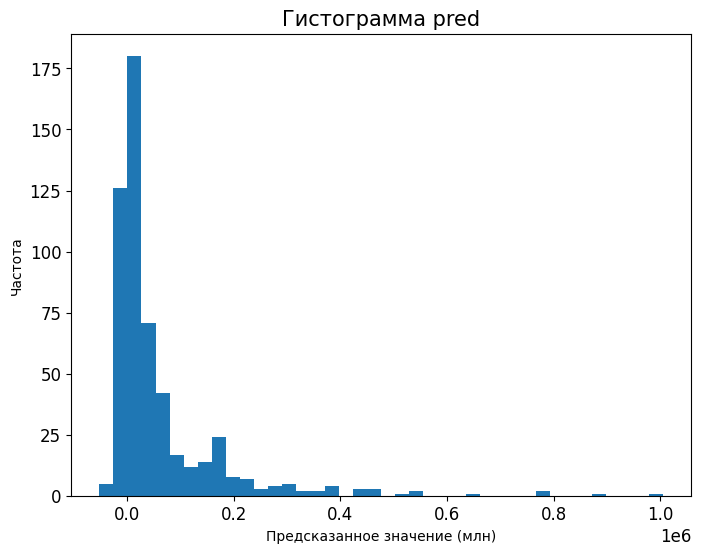

In [586]:
plt.figure(figsize = (8, 6))
plt.hist(pred, bins = 40)
plt.title('Гистограмма pred', fontsize = 15)
plt.xlabel('Предсказанное значение (млн)', fontsize = 10)
plt.ylabel("Частота", fontsize = 10);

Далее для оценки обученной модели посчитаем значения различных метрик

In [587]:
mean_squared_error(y_test, pred)

4380084637.382946

Получаем достаточно **большое значение** среднеквадратичной ошибки. Чем ниже значение MSE, тем лучше модель способна предсказывать целевую переменную. В дальнейшем попытаемся оптимизировать нашу модель, чтобы снизить значение метрики

2. **Mean Absolute Error** - средняя абсолютная ошибка

In [588]:
mean_absolute_error(y_test, pred)

32494.459016955774

Опять-таки получаем большое значение метрики. MAE измеряет среднюю абсолютную разницу между предсказанными значениями модели и фактическими значениями целевой переменной. В нашем случае, обученная **модель ошибается в среднем на 32494 лайка** при предсказывании. Полезным считаем сравнить отклонения нашей модели со стандартным отклонением показателя `likes`

In [589]:
mean_absolute_error(y_test, pred) / df['likes'].std()

0.25584331450589604

Отклонения предсказанных нашей моделью значений от истинных составляет около 25% от стандартного отклонения - приемлемый, но все еще высокий уровень ошибки

3. **R2** - коэффициент детерминации

In [590]:
r2_score(y_test, pred)

0.7408862753707615

Довольно **хороший показатель** метрики говорит о том, что модель объясняет около 74% изменчивости целевой переменной. В других словах, около 74% вариации в целевой переменной может быть объяснено или предсказано с использованием обученной нами модели. Оставшиеся 26% изменчивости могут быть связаны с другими факторами, которые модель не учитывает.

Итак, обучив базовую модель линейной регрессии, **получаем не самые хорошие значения метрик**, несмотря на относительно высокий показатель коэффициента детерминации. В следующем пункте попробуем различными способами оптимизировать обучаемую модель

#### Модель 2 - улучшенная базовая линейная регрессия ####

Для начала отнормируем наши числовые показатели в отрезок от 0 до 1

In [591]:
scaler = preprocessing.MinMaxScaler()

numeric_data = X_train.select_dtypes([np.number])
numeric_features = numeric_data.columns

X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

Далее проведем перебор по сетке для поиска наиболее оптимальных показателей параметров нашей линейной регрессии, используем перебор гиперпараметров по сетке - GridSearchCV. В качестве метрики оценки производительности взято отрицательное значение MSE

In [592]:
params = {'fit_intercept': [True, False],
          'copy_X': [True, False],
          'n_jobs': [-1, 0, 1, 2, 3, 4]}

searcher = GridSearchCV(LinearRegression(), param_grid = params, scoring = 'neg_mean_absolute_error', cv = 4)

searcher.fit(X_train_scaled, y_train)

print(f'Оптимальный метод оптимизации - {searcher.best_params_}, значение Negative MSE - {searcher.best_score_}')

Оптимальный метод оптимизации - {'copy_X': True, 'fit_intercept': True, 'n_jobs': -1}, значение Negative MSE - -32266.06720263864


In [593]:
model = LinearRegression(copy_X = True, fit_intercept = True, n_jobs = -1)
model.fit(X_train_scaled, y_train)
pred = model.predict(X_test_scaled)

Далее для оценки оптимизированной модели посчитаем значения всё тех же метрик

1. **Mean Squared Error** - среднеквадратичная

In [594]:
mean_squared_error(y_test, pred)

4379486171.183333

Всё еще получаем достаточно **большое значение** среднеквадратичной ошибки. Показатель уменьшился лишь на 0.01%

2. **Mean Absolute Error** - средняя абсолютная ошибка

In [595]:
mean_absolute_error(y_test, pred)

32506.50925925926

Опять-таки получаем большое значение метрики. Наблюдаем повышение на 0.03%

3. **R2** - коэффициент детерминации

In [596]:
r2_score(y_test, pred)

0.7409216789802541

Значение метрики увеличилось всего на 0.004%

**В итоге**, использование перебора гиперпараметров по сетке не дало ощутимых результатов. Мы объясняем это тем, что линейная регрессия является относительно простой моделью, и ее производительность может быть не сильно зависима от выбора гиперпараметров.

## Этап 2 - предсказывание отключения комментариев под видео ##



#### Шаг 1 - обучаем модель RandomForestClassifier ####

Для того, чтобы осуществить предсказание бинарной целевой переменной, обучим модель случайного леса (RandomForestClassifier) из библиотеки sklearn.

Для этого нам опять потребуется применить метод One Hot Encoding для переменной `category`. В этот раз мы изнчально решили не использовать столбец `country`, так как уверены в отсутствии зависимости между отключением комментариев и страной, в список трендов которой попало видео.

Итак, в качестве целевой переменной используем столбец `comments_disabled`, в качестве вспомогательных признаков - `category`, `view_count`, `likes`, `subscriber_count`, `ratings_disabled`.

Также форматируем столбцы `rating_disabled` и `comments_disabled` - вместо булевых переменных True и False будем работать с бинарными признаками 1 и 0

In [597]:
df_encoded = pd.get_dummies(df, columns=['category'])

df_encoded['ratings_disabled'] = df_encoded['ratings_disabled'].apply(lambda x: 1 if x == 'True' else 0)
df_encoded['comments_disabled'] = df_encoded['comments_disabled'].apply(lambda x: 1 if x == 'True' else 0)

df_train, df_test = train_test_split(df_encoded, test_size = 0.2, random_state = 42)

X_train = df_train.drop(['title', 'publishedAt', 'channelTitle', 'trending_date', 'tags', 'description', 'daytime', 'country', 'comment_count', 'comments_disabled', 'times_appeared'], axis = 1)
X_test = df_test.drop(['title', 'publishedAt', 'channelTitle', 'trending_date', 'tags', 'description', 'daytime', 'country', 'comment_count', 'comments_disabled', 'times_appeared'], axis = 1)


y_train = df_train['comments_disabled']
y_test = df_test['comments_disabled']

После подготовки всех данных, разделения выборки на тестовую и тренировочную мы готовы приступить к процессу обучения модели и получения предсказаний первого класса

In [598]:
model = RandomForestClassifier(n_estimators=1000,
                               bootstrap = True,
                               max_features = 'sqrt',
                               random_state = 777)

model.fit(X_train, y_train)

pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:, 1]

#### Оценка модели ####

Для оценки обученной модели случайного леса посчитаем значение **ROC AUC**

In [599]:
roc_value = roc_auc_score(y_test, pred_proba)
roc_value

0.690906954887218

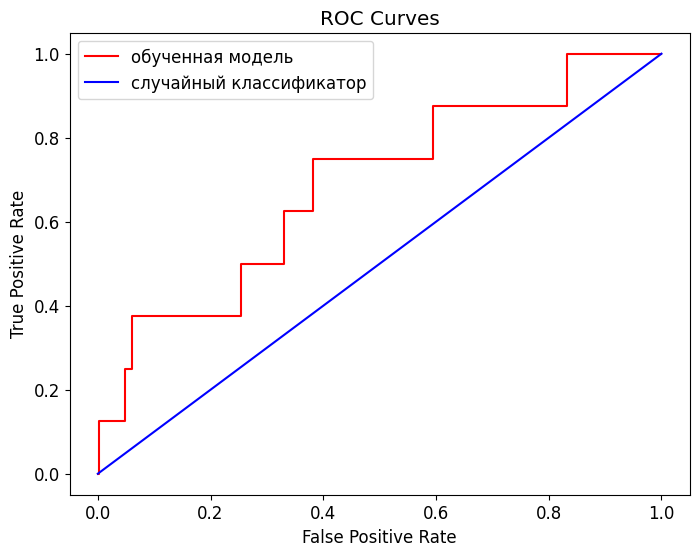

In [600]:
base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
model_fpr, model_tpr, _ = roc_curve(y_test, pred_proba_test)

plt.figure(figsize = (8, 6))

plt.plot(model_fpr, model_tpr, color = 'red', label = 'обученная модель')
plt.plot(base_fpr, base_tpr, color = 'blue', label = 'случайный классификатор')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc = 'upper left');

Показатель ROC AUC измеряет площадь под ROC кривой, которая показывает зависимость между долей верно положительных и долей ложно положительных классификаций при варьировании порога классификации.

Получаем величину площади под ROC кривой - 0.69, наша модель дает результаты лучше случайного классификатора!

Далее оценим нашу модель с помощью построения матрицы путаницы

In [601]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    Функция для построения матрицы была взята из источника: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    plt.figure(figsize = (7, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 14)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 10)
    plt.yticks(tick_marks, classes, size = 10)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 10,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 12)
    plt.xlabel('Predicted label', size = 12);

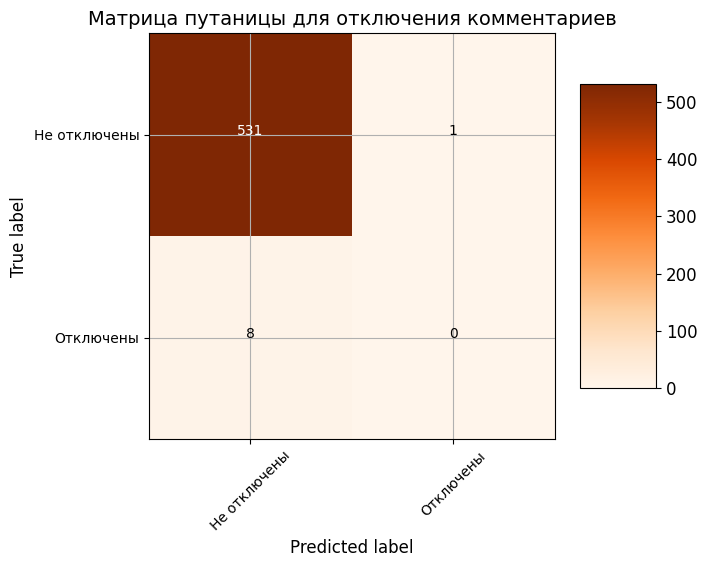

In [602]:
cm = confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes = ['Не отключены', 'Отключены'],
                      title = 'Матрица путаницы для отключения комментариев', normalize=False)

Теперь посмотрим на вляиние тех или иных переменных на предугадывание обученной нами модели

In [603]:
impact = pd.DataFrame({'feature': list(X_train),
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
impact.head()

,feature,importance
1,likes,0.324271
3,subscriber_count,0.295724
0,view_count,0.269945
12,category_News & Politics,0.048442
7,category_Entertainment,0.015147


Подробнее взглянем на взаимосвязи:

> `likes`, `subscriber_count`, `view_count` - видео, набравшее большое количество лайков или просмотров, скорее всего, посвящено какой-то интересной, возможно противоречивой теме. Именно поэтому во избежание нежелательных комментариев или спама, обсуждения под такими видео недоступны

> Видеоролики категории `News & Politics` - видео, связанные с политикой и новостями, могут привлекать большое количество комментариев, включая мнения, спекуляции и различные точки зрения. Это может привести к распространению непроверенных данных, дезинформации или фейковых новостей.

> Видеоролики категории `Entertainment` - видео развлекательного характера часто привлекают широкую аудиторию, и комментарии могут содержать негативные или оскорбительные высказывания. Отключение комментариев помогает предотвратить негативную атмосферу и создать более приятное пространство для зрителей.







#### Шаг 2 - поиск наиболее оптимальных параметров через RandomizedSearchCV ####

После определения необходимых параметров и их значений запускаем процесс перебора и обучаем новую модель согласно полученным оптимальным показателям

In [617]:
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.01)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 1000).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

estimator = RandomForestClassifier(random_state = 777)

rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1,
                        scoring = 'roc_auc', cv = 3,
                        n_iter = 10, verbose = 1, random_state=777)

rs.fit(X_train, y_train)
rs.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


{'n_estimators': 192,
 'min_samples_split': 10,
 'max_leaf_nodes': 35,
 'max_features': 0.6000000000000001,
 'max_depth': 12,
 'bootstrap': True}

In [618]:
model = RandomForestClassifier(n_estimators = 192,
                               min_samples_split = 10,
                               max_leaf_nodes = 35,
                               max_features = 0.6000000000000001,
                               max_depth = 12,
                               bootstrap = True,
                               random_state = 777)

model.fit(X_train, y_train)

pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:, 1]

In [619]:
roc_value = roc_auc_score(y_test, pred_proba)
roc_value

0.6699953007518797

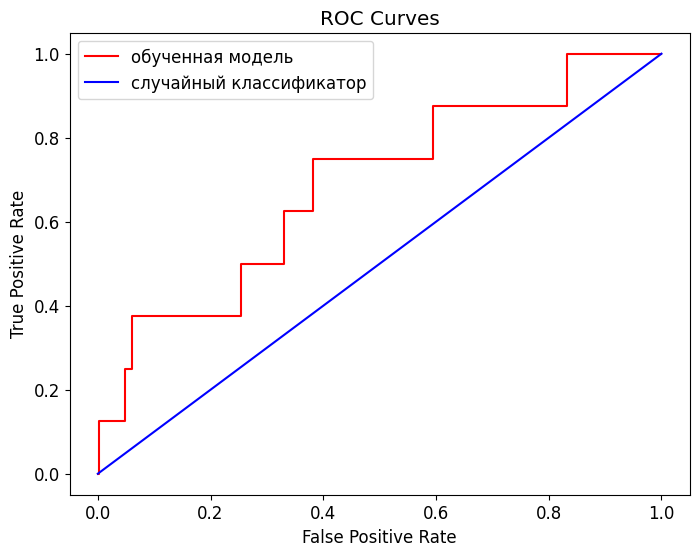

In [620]:
base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
model_fpr, model_tpr, _ = roc_curve(y_test, pred_proba_test)

plt.figure(figsize = (8, 6))

plt.plot(model_fpr, model_tpr, color = 'red', label = 'обученная модель')
plt.plot(base_fpr, base_tpr, color = 'blue', label = 'случайный классификатор')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc = 'upper left');

На удивление, новая модель дает нам более низкие показатели ROC AUC